In [1]:
import networkx as nx
from networkx.generators.random_graphs import _random_subset
import sympy as sp
from sympy import symbols 
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sympy.utilities.lambdify import lambdify


import copy
import time
import random as rd

In [2]:
G = nx.read_adjlist("BA.adjlist")

In [3]:
N = len(G.nodes)

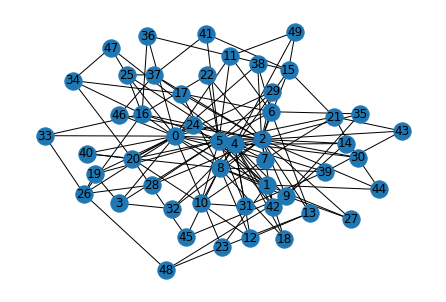

In [4]:
nx.draw(G, with_labels=True)    
plt.show()

In [5]:
adjacency = list(G.adjacency())

In [6]:
A = []
for a, b in adjacency :
    A += [[0]*len(adjacency)]

for a, b in adjacency :
    a = int(a)
    for c in b :
        c = int(c)
        A[a][c] = 1

In [7]:
index = []
for i in range(N):
    for j in range(i+1, N):
        if A[i][j] == 1:
            index += [(i,j)]

removed_link = index[rd.randint(0, len(index)-1)]
links = len(index) - 1

In [8]:
print("It was removed the link between node", removed_link[0], "and node", removed_link[1])

It was removed the link between node 4 and node 42


In [9]:
A[removed_link[0]][removed_link[1]] = 0
A[removed_link[1]][removed_link[0]] = 0

In [10]:
W = symbols(f'w:{links}')
print("There are", links, "indipendent weights")

There are 140 indipendent weights


In [11]:
count = 0
P = copy.deepcopy(A)
for i in range(N):
    for j in range(i+1, N):
        if P[i][j] == 1:
            P[i][j] = W[count]
            P[j][i] = W[count]
            count += 1

In [12]:
with open("BA-pS.txt", "r") as file:
    pS = file.read()
    pS = pS.split("\n")
pS = [float(i) for i in pS]
pS = np.round(pS, 5)

In [13]:
e = (np.dot(pS, P) - pS)**2
E = e[0]
for i in range(1, len(e)):
    E += e[i]

In [14]:
t0 = time.time()

my_func = lambdify(W, E)

def my_func_v(x):
#     return lambdify(W, E)(*tuple(x))
    return my_func(*tuple(x))

def cons1(x, i):
    C = (sum(P[i])-1)**2
    func = lambdify(W, C)
    return func(*tuple(x))

cons = ([{'type' : 'eq', 'fun': lambda x: cons1(x, i)} for i in range(len(P))])

x0 = [1]*links
solution = minimize(my_func_v, x0, bounds = [[0, np.inf]]*len(x0), constraints=cons).x

print(f"done in {int((time.time()-t0)/60)} minutes and {((time.time()-t0)%60)} seconds")

done in 1 minutes and 15.672826290130615 seconds


In [15]:
count = 0
P_new = copy.deepcopy(A)
for i in range(N):
    for j in range(i+1, N):
        if P_new[i][j] == 1:
            P_new[i][j] = solution[count]
            P_new[j][i] = solution[count]
            count += 1

In [16]:
P_new

[[0,
  1.0,
  1.0,
  1.0,
  1.0,
  0,
  1.0,
  1.0,
  0,
  0,
  0,
  1.0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1.0,
  1.0,
  0,
  0,
  1.0,
  1.0,
  1.0,
  1.0,
  0,
  0,
  1.0,
  0,
  0,
  0,
  1.0,
  0,
  0,
  1.0,
  0,
  1.0,
  0,
  1.0,
  0,
  0,
  0,
  0,
  0,
  1.0,
  0,
  0,
  0],
 [1.0,
  0,
  0,
  0,
  1.0,
  1.0,
  0,
  0,
  1.0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1.0,
  0,
  0,
  0,
  0,
  1.0,
  1.0,
  0,
  0,
  1.0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1.0,
  0,
  0,
  0,
  0,
  0],
 [1.0,
  0,
  0,
  0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0,
  0,
  0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0,
  0,
  0,
  0,
  1.0,
  0,
  0,
  0,
  0,
  1.0,
  1.0,
  1.0,
  1.0,
  0,
  1.0,
  0,
  0,
  1.0,
  0,
  1.0,
  1.0,
  0,
  0,
  0,
  1.0,
  1.0,
  1.0,
  0,
  1.0,
  0,
  0,
  0],
 [1.0,
  0,
  0,
  0,
  0,
  1.0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1.0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,


In [17]:
matrixP = np.array(P_new)

In [18]:
autovaloriP, autovettoriP = np.linalg.eig(np.transpose(matrixP))
autovettoriP = np.transpose(autovettoriP)

In [19]:
for i in range(N):
    if np.round(autovaloriP[i], 1) == 1:
        pS_new = autovettoriP[i]
        print("Eigenvector found")
        break
np.round(autovaloriP.real, 1)

array([ 8.2, -4.9,  4.3,  3.8, -4.3, -3.9,  3.3, -3.5, -3.4,  2.7,  2.5,
        2.5, -2.7, -2.5, -2.4, -2.2,  2.2,  2. ,  1.8,  1.7,  1.6, -1.9,
       -1.8, -1.7,  1.4,  1.2,  1.2, -1.5, -1.3, -1.2, -1.2, -0.9,  0.8,
       -0.8, -0.7, -0.6,  0.6,  0.6,  0.5,  0.4,  0.3,  0.1,  0.1, -0.4,
       -0.2, -0.2,  0. ,  0. ,  0. ,  0. ])

In [20]:
if pS_new[0] < 0:
    pS_new = -pS_new

NameError: name 'pS_new' is not defined

In [ ]:
pS_new = pS_new.real

In [ ]:
fig, ax = plt.subplots(figsize=(0.5*N, 5))

pSNorm = [h/sum(pS) for h in pS]
pSNorm_new = [abs(h)/sum(abs(pS_new)) for h in pS_new]
nodes = sorted([int(n) for n in G.nodes])

ax.bar(nodes, pSNorm, width=0.4, align='edge', color='blue', label="original eigenvector")
ax.bar(nodes, pSNorm_new, width=-0.4, align='edge', color='orange', label="new eigenvector")

ax.set_xticks(np.arange(0, N, 1))
ax.legend()
plt.show()

In [ ]:
for i in range(len(P_new)):
    print(sum(P_new[i]))

In [ ]:
walker_per_node = 200

In [ ]:
seed = np.random.RandomState()
def dynamic_evolution(G, history = []):
    evolution = [0] * N
    for n in G.nodes:
        for i in range(G.nodes[n]['N_i']):
            neightbours = []
            n = int(n)
            for ind in range(len(P_new[n])):
                if P_new[n][ind] != 0:
                    if len(neightbours) != 0:
                        neightbours += [[ind, P_new[n][ind] + neightbours[-1][1]]]
                    else:
                        neightbours += [[ind, P_new[n][ind]]]
            s = sum(P_new[n])
            prob = rd.uniform(0., s)

            for neigh, p in neightbours:
                if prob <= p:
                    evolution[neigh] += 1
                    break
    for n in G.nodes:
        G.nodes[n]['N_i'] = evolution[int(n)]
    history += [evolution]

In [ ]:
history = [[], [], []]
for h in range(len(history)):
    history[h] = [[walker_per_node] * len(G.nodes)]

In [ ]:
time_steps = int(5e1)

In [ ]:
t0 = time.time()

for h in range(len(history)):
    h = int(h)
    for n in G.nodes:
        G.nodes[n]['N_i'] = walker_per_node
    
    for t in range(time_steps):
#         t1 = time.time()
        dynamic_evolution(G, history[h])
#         print(f"done in {int((time.time()-t1)/60)} minutes and {((time.time()-t1)%60)} seconds")

print(f"done in {int((time.time()-t0)/60)} minutes and {((time.time()-t0)%60)} seconds")

In [ ]:
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize=(0.5*N, 10))

pSNorm = [h/sum(pS) for h in pS]
pSNorm_new = [h/sum(abs(pS_new)) for h in pS_new]
nodes = sorted([int(n) for n in G.nodes])

ax[0].bar(nodes, pSNorm, width=0.4, align='edge', color='blue', label="original eigenvector")
ax[0].bar(nodes, pSNorm_new, width=-0.4, align='edge', color='orange', label="new eigenvector")

# hMean = [[(h1+h2+h3)/walker_per_node/N/3 
#           for h1, h2, h3 in zip(history[0][i], history[1][i], history[2][i])] 
#          for i in range(len(history[0]))]

ax[1].bar(nodes, [h/sum(history[0][-1]) for h in history[0][-1]], width=0.4, 
          align='edge', color='orange', label='relaxed distribution')
# ax[1].bar(nodes, hMean[-1], width=0.2, align='edge', color='red', label='mean relaxed distribution')
ax[1].bar(nodes, pSNorm_new, width=-0.4, align='edge', color='tab:cyan', label="new eigenvector")

for i in [0,1]:
    ax[i].legend()
    ax[i].set_xlabel("Nodes")
    ax[i].set_ylabel("Occupation (%)")
    ax[i].set_xticks(np.arange(0, N, 1))
#     ax[i].grid(True)


plt.show()